In [1]:
import os
import sys
sys.path.append("../")
from models.unet import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
from data.datasets import WeatherBench
import torch
from models.diffusion import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri

device = "cuda"

plt.rcParams['image.cmap'] = 'cmc.vik'

In [2]:
test_dataset = WeatherBench(
    var="test",
    downscaling_factor=2,
    normalize=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
lat_lon, t= test_dataset.get_grid()
lat,lon = lat_lon

# Index of input t2m
t2m = 1

In [3]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 25
t_steps = 50

In [4]:
for target, input in test_loader:
    input = input.to(device)
    target = target.to(device)
    break

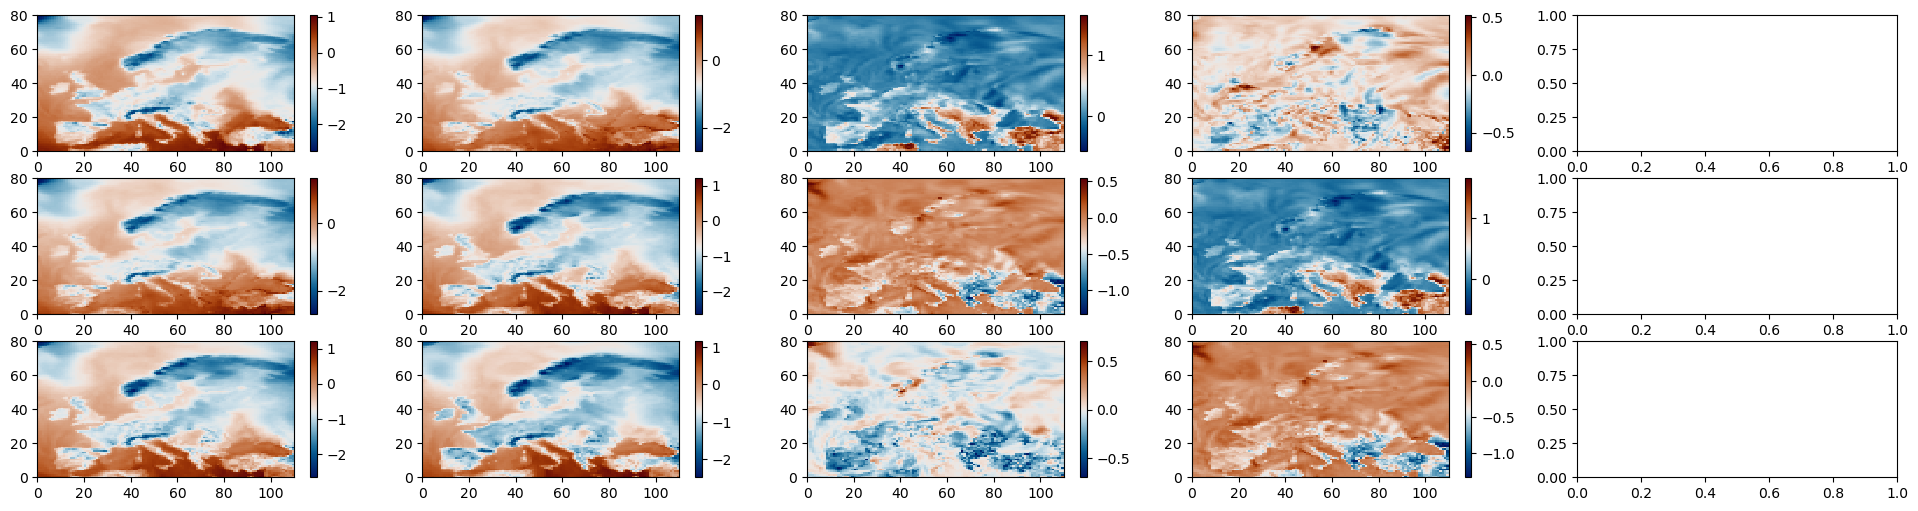

In [5]:
fig, axs = plt.subplots(3, 5, figsize=(24, 6))

input_last_t = input[:,t2m].cpu()
target = target.cpu()
for i in range(3):
    # Input
    im1 = axs[i,0].pcolormesh(input_last_t[i].numpy())
    plt.colorbar(im1)
    # Truth
    im2 = axs[i,1].pcolormesh(target[i,0].numpy() + input_last_t[i].numpy())
    plt.colorbar(im2)
    # Truth Residual
    im3 = axs[i,2].pcolormesh(target[i,0].numpy())
    plt.colorbar(im3)

    im4 = axs[i,3].pcolormesh(input[i,1].cpu() - input[i,0].cpu())
    plt.colorbar(im4)


# Deterministic

In [6]:
ckpt_path = "../results/20250807_194754_debug/Datetime_20250807_195231_Loss_WeatherBench_UNet_diffusion_deterministic_T50_DDIM1.pt"
distributional_method = "deterministic"

In [9]:
model =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_545444/272260365.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [10]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps = n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

In [11]:
input.shape, target.shape, pred.shape

(torch.Size([3, 12, 80, 110]),
 torch.Size([3, 1, 80, 110]),
 torch.Size([3, 1, 80, 110, 25]))

Text(0.5, 1.0, 'Residual sample')

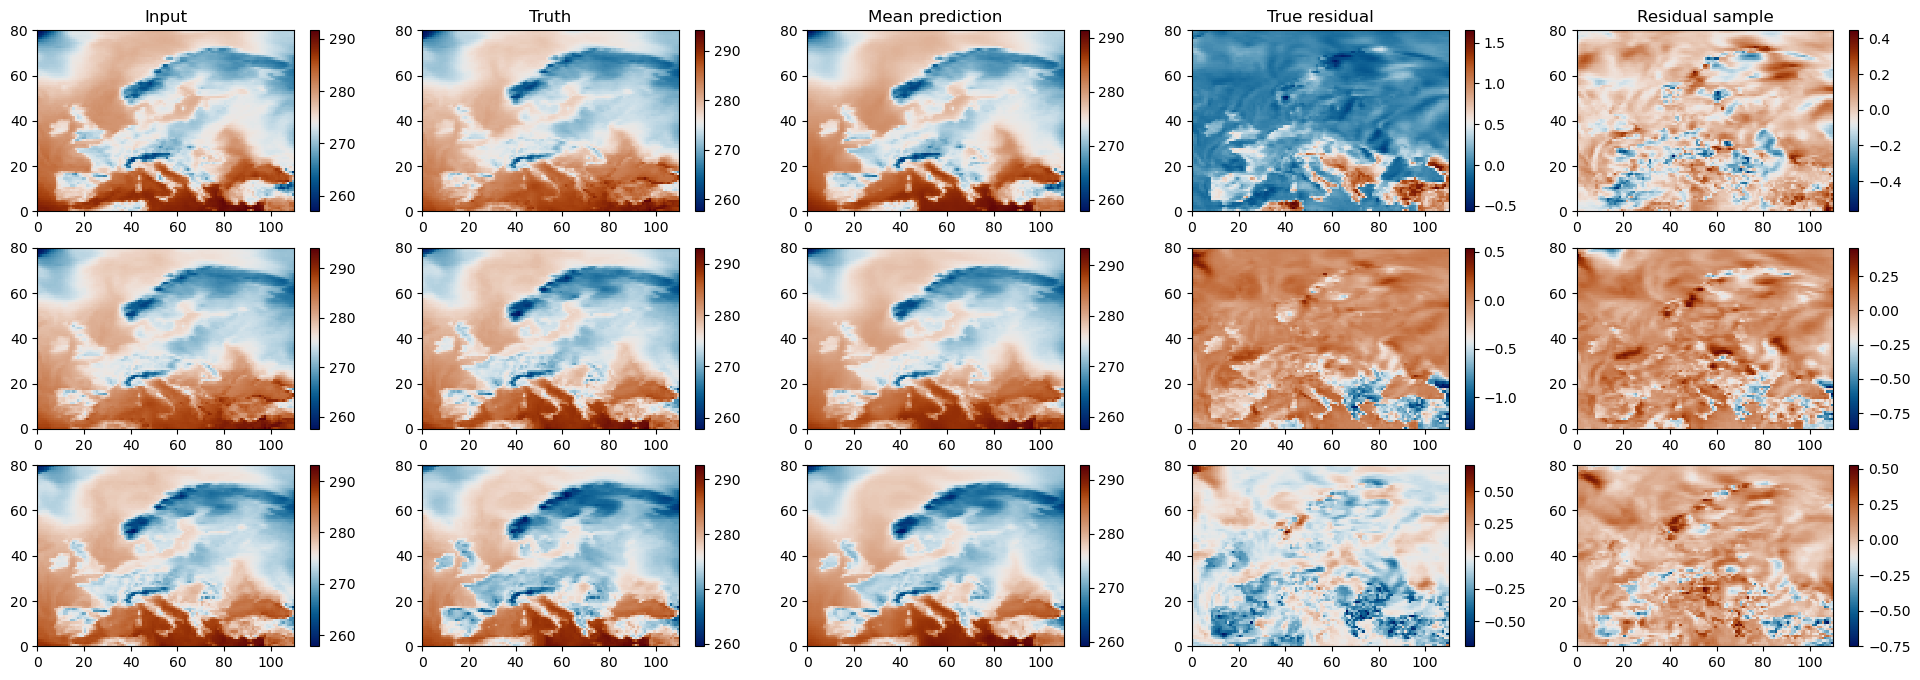

In [12]:
fig, axs = plt.subplots(3, 5, figsize=(24, 8))

input_last_t = input[:,t2m].cpu()
mean_prediction = pred[:,0].mean(axis = -1).cpu()
pred = pred.cpu()
target = target.cpu()
for i in range(3):
    residual = target[i,0].numpy()
    inp = test_dataset.destandardize_output(input_last_t[i]).numpy()
    truth = test_dataset.destandardize_output(target[i,0] + input_last_t[i]).numpy()
    mean_pred = test_dataset.destandardize_output(mean_prediction[i] + input_last_t[i]).numpy()

    # Input
    im1 = axs[i,0].pcolormesh(inp)
    plt.colorbar(im1)

    # Truth
    im2 = axs[i,1].pcolormesh(truth)
    plt.colorbar(im2)

    # Mean prediction
    im5 = axs[i,2].pcolormesh(mean_pred)
    plt.colorbar(im5)

    # Truth Residual
    im3 = axs[i,3].pcolormesh(residual)
    plt.colorbar(im3)

    # Trajectory
    im4 = axs[i,4].pcolormesh(pred[i,0,...,0].numpy())
    plt.colorbar(im4)




axs[0,0].set_title("Input")
axs[0,1].set_title("Truth")
axs[0,2].set_title("Mean prediction")
axs[0,3].set_title("True residual")
axs[0,4].set_title("Residual sample")


In [ ]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

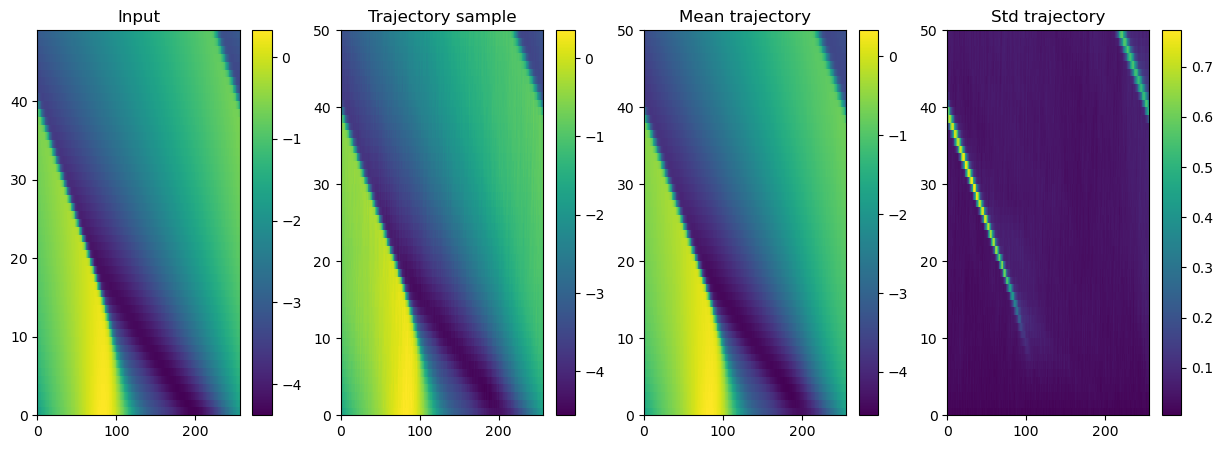

In [12]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Input")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Normal

In [54]:
ckpt_path = "../results/20250730_133121_debug/Datetime_20250730_133121_Loss_1D_Burgers_UNet_diffusion_normal_DDIM0.pt"
distributional_method = "normal"

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

ddim_churn = 1

/tmp/ipykernel_409285/1964846415.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    ddim_churn=ddim_churn
)

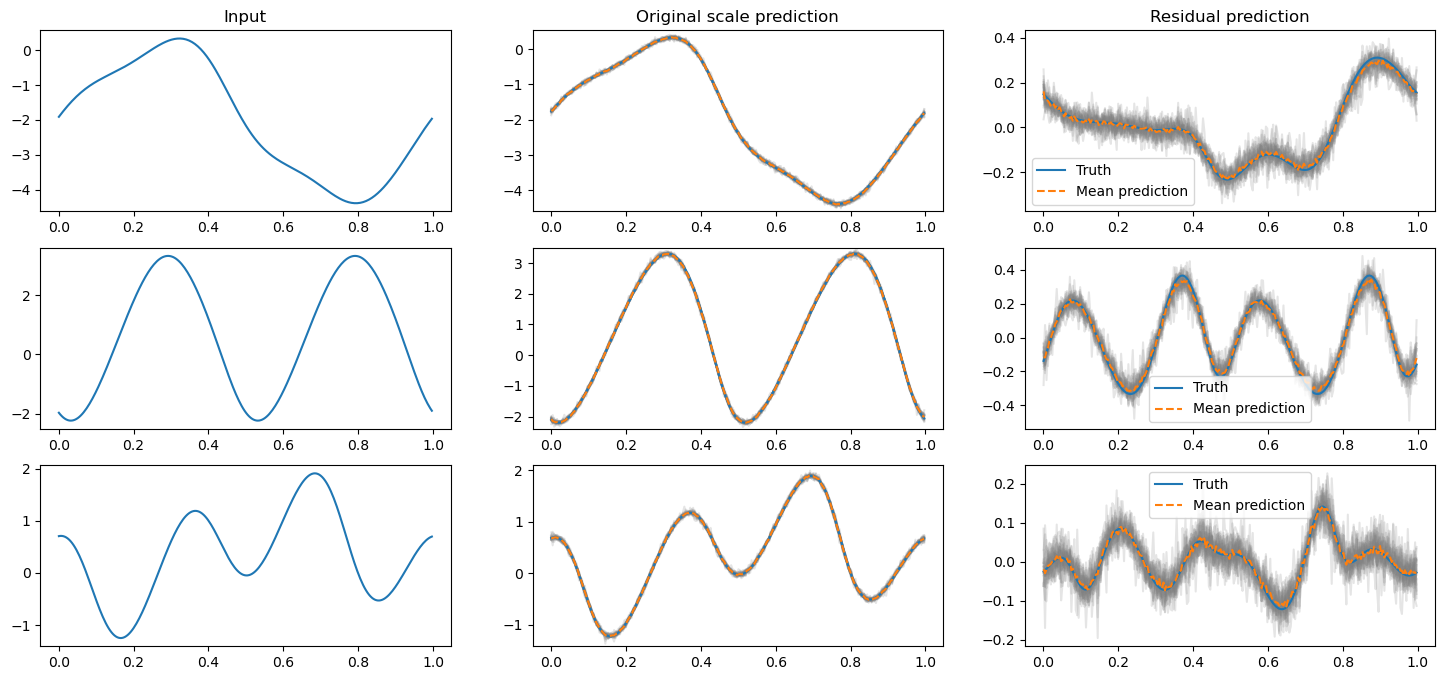

In [63]:
plot_predictions(input, target, pred, grid)

In [69]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [70]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            ddim_churn=ddim_churn
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

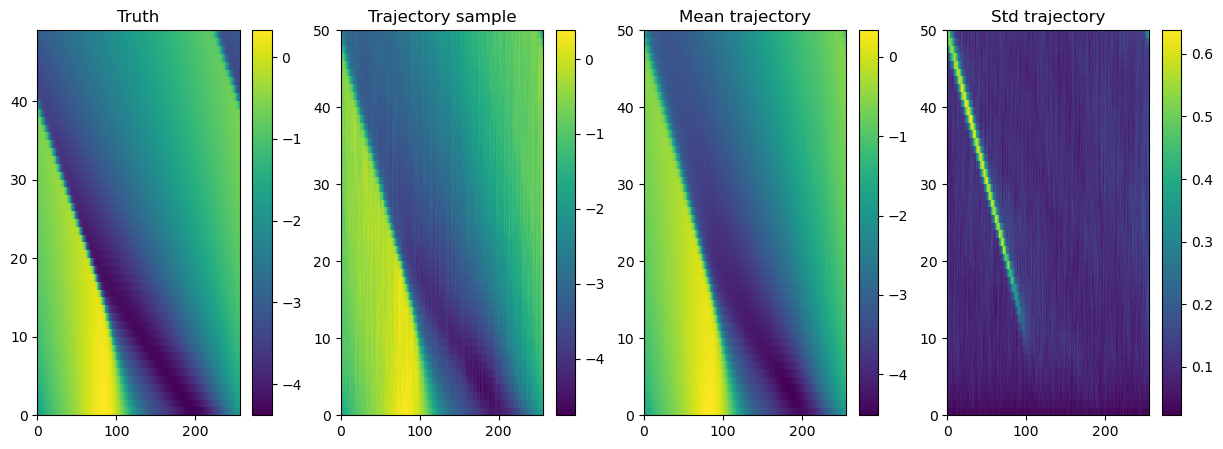

In [72]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Mixed normal

In [29]:
ckpt_path = "../results/Burgers_mixednormal/Datetime_20250728_090412_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "mixednormal"

In [30]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    n_components=10,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_409285/952606495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [22]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

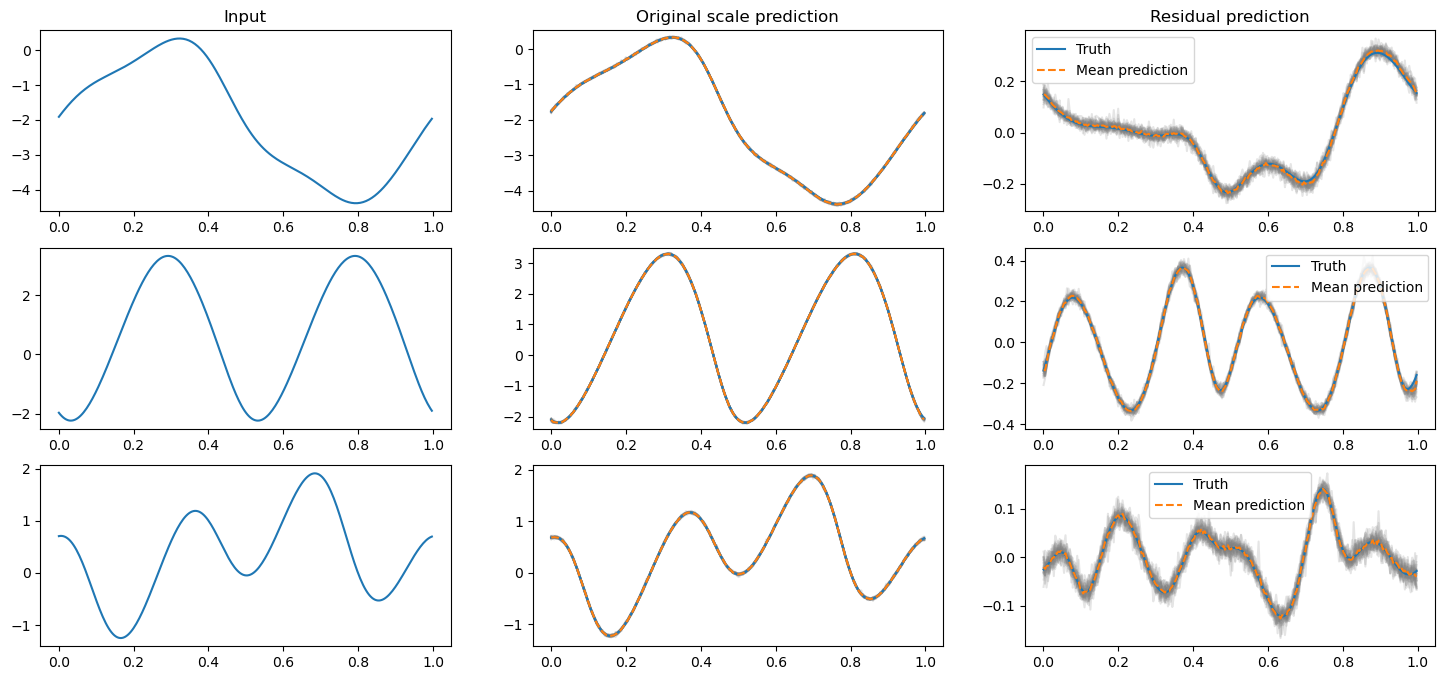

In [23]:
plot_predictions(input, target, pred, grid)

In [24]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [26]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

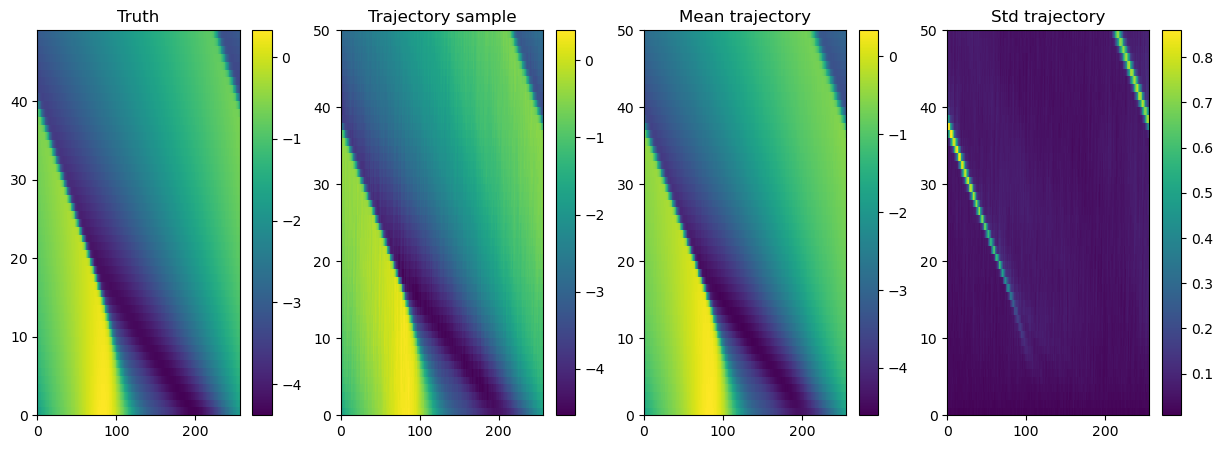

In [28]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Sample

In [7]:
ckpt_path = "../results/Burgers_sample/Datetime_20250728_114053_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "sample"

In [8]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=4,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )


model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=64
)



dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_409285/2306179049.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [9]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

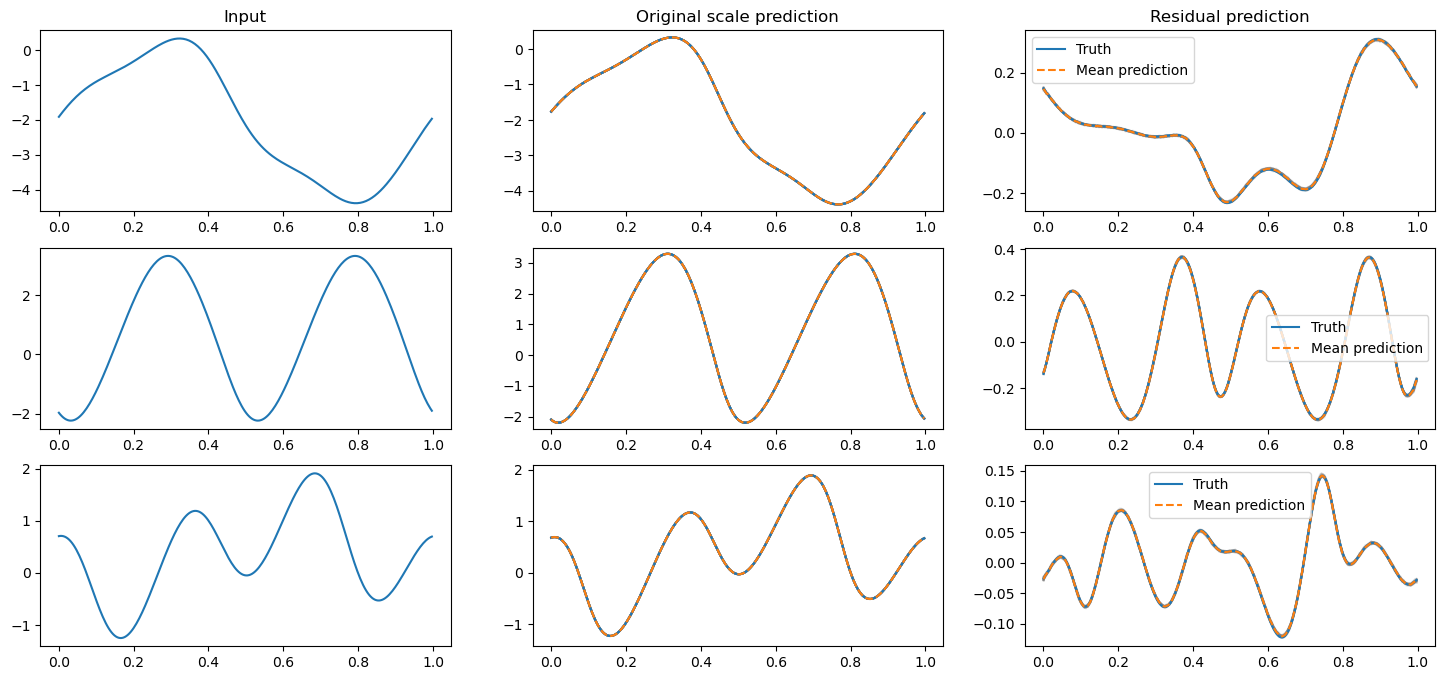

In [10]:
plot_predictions(input, target, pred, grid)

In [11]:

grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

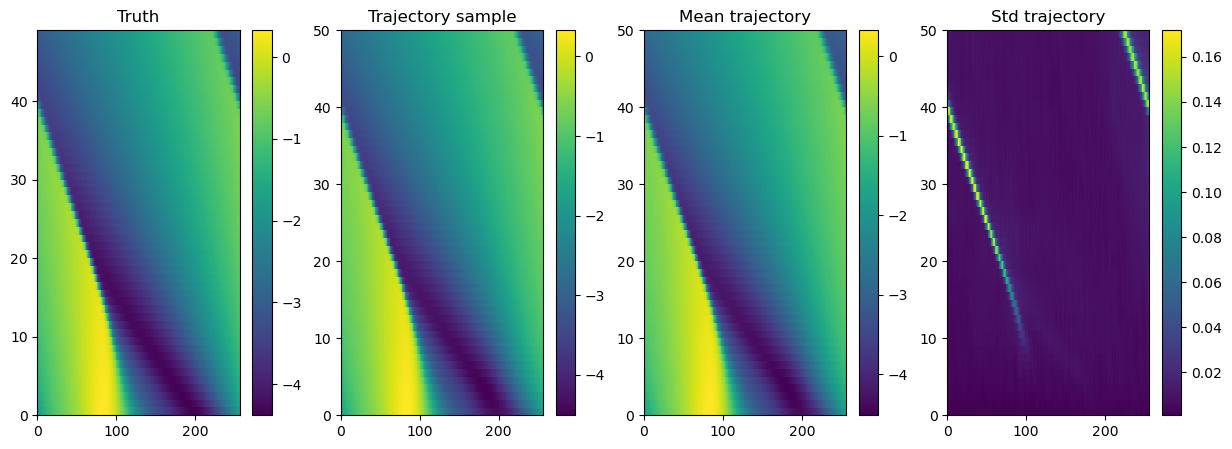

In [12]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Multivariate normal

In [13]:
ckpt_path = "../results/Burgers_mvnormal/Datetime_20250729_055313_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "mvnormal"

In [14]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

#backbone.conditioning_projection = torch.nn.Identity()

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 10,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_409285/732789396.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [15]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

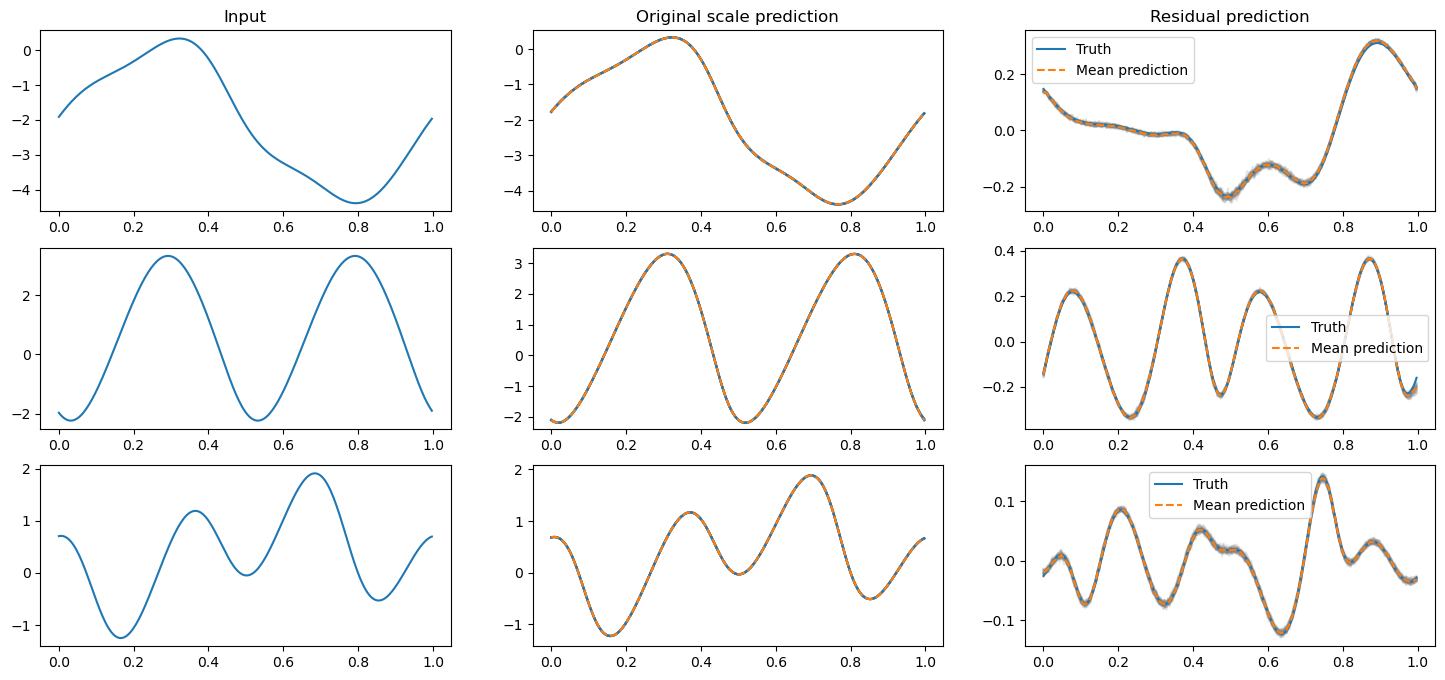

In [16]:
plot_predictions(input, target, pred, grid)

In [17]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

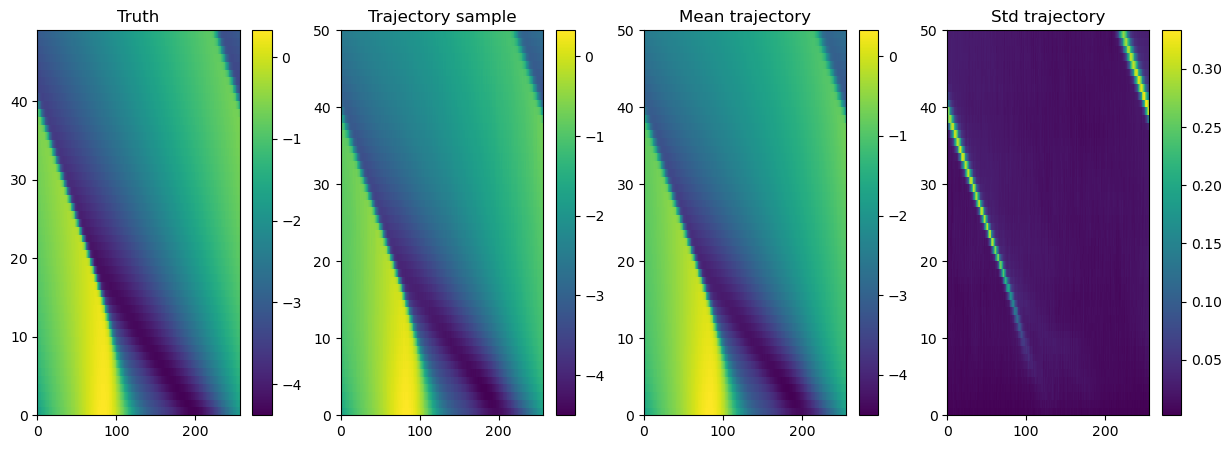

In [19]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

: 

: 

: 

: 